In [1]:
#import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the data (corresponding to the short term forecast in R)
data=pd.read_csv('data_final_day_Rand.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.head()

,DEXSFUS,dfit_arim1,dfit_esp1,dfit_lrf1,dres_arim1,dres_esp1,dres_lrf1,dfit_tarim1,dfit_tesp1,dres_tarim1,dres_tesp1,signal1,noice1
DATE,,,,,,,,,,,,,
2015-01-01,11.5425,11.530958,11.541389,11.748431,0.011542,0.000096,-0.205931,11.732484,11.755736,0.011544,-0.011708,11.744028,-0.201528
2015-01-02,11.6990,11.542500,11.542500,11.696556,0.156500,0.013559,0.002444,11.683493,11.674511,-0.002479,0.006503,11.681013,0.017987
2015-01-05,11.7155,11.699000,11.698984,11.630803,0.016500,0.001412,0.084697,11.605702,11.619342,-0.000157,-0.013796,11.605545,0.109955
2015-01-06,11.7005,11.715500,11.715498,11.556821,-0.015000,-0.001280,0.143679,11.521644,11.531691,0.000767,-0.009280,11.522411,0.178089
2015-01-07,11.7075,11.700500,11.700502,11.478391,0.007000,0.000598,0.229109,11.436533,11.441052,-0.000141,-0.004660,11.436392,0.271108


In [3]:
# This function is to transform a time series dataset into a format suitable for training machine learning models, where:
# X contains sequences of past observations (input features). y contains the next observation (target value) that the model will learn to predict.
def data_toX_y (data, window):
    data_np=data.to_numpy()
    X=[]
    y=[]
    for i in range(len(data_np)-window):
        row= [[a] for a in data_np[i:i+window]]
        X.append(row)
        label=data_np[i+window]
        y.append(label)
    return np.array(X), np.array(y)

In [4]:
# The function help to evaluate the performances of each model
def metrics(y_true, y_pred):
    # Convert inputs to lists
    y_true_list = np.array(y_true)
    y_pred_list = np.array(y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(y_true_list) - np.array(y_pred_list)) ** 2))
    
    # Calculate SMAPE
    smape = np.mean(np.abs(y_true_list-y_pred_list )/((np.abs(y_true_list)+np.abs(y_pred_list))/2))
    
    return rmse, smape

# Performances of single models

We are only interested in the results of the test set, as the forecasts were done differently

In [5]:
#Arima
print('test:' , metrics(data['DEXSFUS'][2067:],data['dfit_arim1'][2067:]))

test: (np.float64(0.19963124289184575), np.float64(0.009550275705635481))


In [6]:
#ES
print('test:' , metrics(data['DEXSFUS'][2067:],data['dfit_esp1'][2067:]))

test: (np.float64(0.1995920151944577), np.float64(0.009506922801366214))


In [7]:
#SSA-R
print('test:' , metrics(data['DEXSFUS'][2067:],data['dfit_lrf1'][2067:]))

test: (np.float64(0.21900756717837824), np.float64(0.010561441147166114))


# ARIMA-LSTM (LSTM on residuals of Arima)

In [11]:
# We scale the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
data_ = np.array(data['dres_arim1']).reshape(-1, 1)
data_= scaler.fit_transform(data_)
data_=pd.Series(data_.reshape(-1))
s=data_[:5]
data_=pd.concat([s,data_])

In [12]:
### Divide the data to train and test
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2067, 5, 1), (2067,), (20, 5, 1), (20,))

In [13]:
# Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [14]:
##LSTM structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(200, return_sequences=True))
m.add(LSTM(50))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 200)              │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,851 (827.54 KB)

 Trainable params: 211,851 (827.54 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0933 - root_mean_squared_error: 0.2889 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - l

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0078 - root_mean_squared_error: 0.0879 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

In [16]:
#Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [17]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

test_p=m.predict(X_test).flatten()
test_p[:20]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([0.21781407, 0.1358007 , 0.04782753, 0.        , 0.        ,
       0.1265569 , 0.23857531, 0.02840179, 0.        , 0.3041839 ,
       0.27140746, 0.00034855, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00232102, 0.        , 0.        ],
      dtype=float32)

In [18]:
# Inversion of the scaling
train_p=scaler.inverse_transform(train_p.reshape(-1,1))
test_p=scaler.inverse_transform(test_p.reshape(-1,1))
train_p=train_p.reshape(-1)
test_p=test_p.reshape(-1)

In [20]:
# ARIMA-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).
print('test:' , metrics(data['DEXSFUS'][2067:],data['dfit_arim1'][2067:]+test_p))

test: (np.float64(0.19878640454649102), np.float64(0.009505102086844602))


# ES-LSTM (LSTM on residuals of ES )

For this cas the code is the same that the case of ARIMA-LSTM but we just replace dres_arim1 and dfit_arim1 by dres_esp1 and dfit_esp1 respectively

# SSA-R-LSTM (LSTM on the noice )

In [8]:
#Prepare the data
data_=data['dres_lrf1']
s=data_[:5]
data_=pd.concat([s,data_])

###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [9]:
# Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [10]:
del m

NameError: name 'm' is not defined

In [11]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [13]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1610
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0257 - root_mean_squared_error: 0.1601 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0238 - root_mean_squared_error: 0.1540 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0233 - root_mean_squared_error: 0.1526 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0233 - root_mean_squared_error: 0.1524 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss

In [14]:
#Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [15]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

test_p=m.predict(X_test).flatten()
test_p[:20]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [16]:
# SSA-R-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('test:' , metrics(data['DEXSFUS'][2067:],data['dfit_lrf1'][2067:]+test_p))

test: (np.float64(0.2046579904328283), np.float64(0.010120707032134836))


# SSA-ARIMA-LSTM (LSTM on residuals of SSA-ARIMA and LSTM on the noise)

LSTM on residuals of SSA-ARIMA

In [97]:
# We scale the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
data_ = np.array(data['dres_tarim1']).reshape(-1, 1)
data_= scaler.fit_transform(data_)
data_=pd.Series(data_.reshape(-1))
s=data_[:5]
data_=pd.concat([s,data_])

In [98]:
# Prepare the data
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [99]:
# Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [100]:
# delete the previous model
del m

In [101]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(200, return_sequences=True))
m.add(LSTM(50))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 5, 200)              │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 50)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,851 (827.54 KB)

 Trainable params: 211,851 (827.54 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [103]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0578 - root_mean_squared_error: 0.2236 - val_loss: 1.6795e-04 - val_root_mean_squared_error: 0.0130
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1330e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.7344e-04 - val_root_mean_squared_error: 0.0132
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5923e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.6861e-04 - val_root_mean_squared_error: 0.0130
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4621e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.6654e-04 - val_root_mean_squared_error: 0.0129
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4703e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.6584e-04 - val_root_mean_squared_error: 0.0129
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4984e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.6548e-04 - val_root_mean_squared_error: 0.0129
Epoch 7/100
5

Epoch 42/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1566e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.6610e-04 - val_root_mean_squared_error: 0.0129
Epoch 43/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2030e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.6545e-04 - val_root_mean_squared_error: 0.0129
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2629e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.6493e-04 - val_root_mean_squared_error: 0.0128
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3332e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6449e-04 - val_root_mean_squared_error: 0.0128
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4097e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6411e-04 - val_root_mean_squared_error: 0.0128
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4878e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.6382e-04 - val_root_mean_squared_error: 0.0128
Ep

Epoch 83/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4463e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6094e-04 - val_root_mean_squared_error: 0.0127
Epoch 84/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4318e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6086e-04 - val_root_mean_squared_error: 0.0127
Epoch 85/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4177e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6078e-04 - val_root_mean_squared_error: 0.0127
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4038e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6071e-04 - val_root_mean_squared_error: 0.0127
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3903e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6064e-04 - val_root_mean_squared_error: 0.0127
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3771e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6057e-04 - val_root_mean_squared_error: 0.0127


In [104]:
# predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [105]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

# Generate 20 Forecat
test_p=m.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [106]:
# Inversion of the scaling
train_p=scaler.inverse_transform(train_p.reshape(-1,1))
test_p=scaler.inverse_transform(test_p.reshape(-1,1))
train_p=train_p.reshape(-1)
test_p=test_p.reshape(-1)

In [107]:
# Save the results of the SSA-ARIMA residuals
train_p1=train_p
test_p1=test_p

LSTM on the noise

In [108]:
#prepare the data
data_=data['noice1']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [109]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [110]:
del m

In [111]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [113]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1608
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0258 - root_mean_squared_error: 0.1604 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0245 - root_mean_squared_error: 0.1563 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1547
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0240 - root_mean_squared_error: 0.1546 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1544
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0235 - root_mean_squared_error: 0.1530 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss:

In [114]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [115]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

test_p=m.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [116]:
# Add the results to the previous residual of SSA-ARIMA 
train_p=train_p1+train_p
test_p=test_p1+test_p

In [117]:
# SSA-ARIMA-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('test:' , metrics(data['DEXSFUS'][2067:],data['dfit_tarim1'][2067:]+test_p))

test: (np.float64(0.17684958497591663), np.float64(0.008920032505870253))


# SSA-ES-LSTM (LSTM on residuals of SSA-ES and LSTM on the noise)

For this cas the code is the same that the case of SSA-ARIMA-LSTM but we just replace dres_tarim1 and dfit_tarim1 by dres_tesp1 and dfit_tesp1 respectively

# SSA-LSTM-LSTM (LSTM on reconstructed signal and  LSTM on the noise)

LSTM on signal

In [118]:
#prepare the data
data_=data['signal1']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [119]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [120]:
# delete the previous model
del m

In [121]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [123]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 68.6817 - root_mean_squared_error: 7.8986 - val_loss: 4.0746 - val_root_mean_squared_error: 2.0186
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3168 - root_mean_squared_error: 1.5218 - val_loss: 3.5354 - val_root_mean_squared_error: 1.8803
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2533 - root_mean_squared_error: 1.5009 - val_loss: 3.5016 - val_root_mean_squared_error: 1.8713
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2103 - root_mean_squared_error: 1.4865 - val_loss: 3.3982 - val_root_mean_squared_error: 1.8434
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1464 - root_mean_squared_error: 1.4648 - val_loss: 3.1571 - val_root_mean_squared_error: 1.7768
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0523 - root_mean_squared_error: 1.4323 - val_loss: 3.0434 - val_root_mean_squared_error: 1.7445
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0134 - root_mean_squared_error: 0.1150 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0133 - root_mean_squared_error: 0.1145 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0132 - root_mean_squared_error: 0.1140 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0130 - root_mean_squared_error: 0.1135 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0129 - root_mean_squared_error: 0.1131 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0128 - root_mean_squared_error: 0.1126 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1003 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0101 - root_mean_squared_error: 0.1000 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0100 - root_mean_squared_error: 0.0996 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0100 - root_mean_squared_error: 0.0993 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0099 - root_mean_squared_error: 0.0990 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0098 - root_mean_squared_error: 0.0986 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss

In [124]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [125]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

test_p=m.predict(X_test).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [126]:
# Save the results of the SSA-LSTM residuals
train_p1=train_p
test_p1=test_p

LSTM on the noice

In [127]:
#prepare the data
data_=data['noice1']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [128]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [129]:
# delete the previous model
del m

In [130]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [132]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1608
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0258 - root_mean_squared_error: 0.1604 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0245 - root_mean_squared_error: 0.1563 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1547
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0240 - root_mean_squared_error: 0.1546 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1544
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0235 - root_mean_squared_error: 0.1530 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1511 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss

In [133]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [134]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

test_p=m.predict(X_test).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [135]:
# Add the results to the previous residual of SSA-LSTM
# The result is already the SSA-LSTM-LSTM
train_p=train_p1+train_p
test_p=test_p1+test_p

In [136]:
# SSA-LSTM-LSTM (we sum the results of the fitted ARIMA model with the forecast of the residuals).

print('test:' , metrics(data['DEXSFUS'][2067:],test_p))

test: (np.float64(0.1981962332742565), np.float64(0.00995599239408616))


# LSTM

In [137]:
#prepare the data
data_=data['DEXSFUS']
s=data_[:5]
data_=pd.concat([s,data_])
###
window=5
X,y=data_toX_y(data_,window)

X_train,y_train= X[:2067],y[:2067]
X_test,y_test= X[2067:],y[2067:]

In [138]:
#Set the seed
tf.keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [139]:
# delete the previous model
del m

In [140]:
#LSTM Structure
m=Sequential()
m.add(InputLayer((5,1)))
m.add(LSTM(250))
m.add(Dense(1,'relu'))
m.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 250)                 │         252,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,251 (985.36 KB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
#Compile the model
m.compile(loss=MeanSquaredError(),optimizer="Adam",metrics=[RootMeanSquaredError()])

In [142]:
#Train the model
history=m.fit(X_train,y_train,validation_split=0.2, epochs=100 ,batch_size=32)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 68.9146 - root_mean_squared_error: 7.9131 - val_loss: 4.1320 - val_root_mean_squared_error: 2.0327
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3382 - root_mean_squared_error: 1.5289 - val_loss: 3.6169 - val_root_mean_squared_error: 1.9018
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2669 - root_mean_squared_error: 1.5055 - val_loss: 3.6002 - val_root_mean_squared_error: 1.8974
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2239 - root_mean_squared_error: 1.4911 - val_loss: 3.5003 - val_root_mean_squared_error: 1.8709
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1605 - root_mean_squared_error: 1.4697 - val_loss: 3.2702 - val_root_mean_squared_error: 1.8084
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0685 - root_mean_squared_error: 1.4380 - val_loss: 3.1703 - val_root_mean_squared_error: 1.7805
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0482 - root_mean_squared_error: 0.2186 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2142
Epoch 44/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0479 - root_mean_squared_error: 0.2180 - val_loss: 0.0456 - val_root_mean_squared_error: 0.2135
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0476 - root_mean_squared_error: 0.2173 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2128
Epoch 46/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0474 - root_mean_squared_error: 0.2167 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2120
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0471 - root_mean_squared_error: 0.2161 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2113
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0468 - root_mean_squared_error: 0.2155 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2105
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0384 - root_mean_squared_error: 0.1950 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 86/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0382 - root_mean_squared_error: 0.1946 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1782
Epoch 87/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0381 - root_mean_squared_error: 0.1942 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1774
Epoch 88/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0379 - root_mean_squared_error: 0.1938 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1765
Epoch 89/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0378 - root_mean_squared_error: 0.1935 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1756
Epoch 90/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0377 - root_mean_squared_error: 0.1931 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 91/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


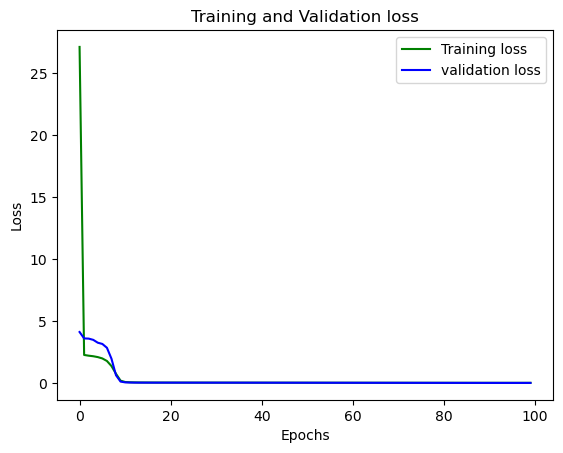

In [77]:
print(history.history.keys())

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('')
plt.show()

In [143]:
# Predict the train set
train_p=m.predict(X_train).flatten()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [144]:
# Here the forecast is done based on the test set
# The forecast is done such that the model incorporate at each step the true/actual value to forecast the next one

test_p=m.predict(X_test).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [145]:
#LSTM 
print('test:' , metrics(data['DEXSFUS'][2067:],test_p))

test: (np.float64(0.1899454827835107), np.float64(0.008724711500500405))
